## Preparation

Text(0.5,1,'S&P500 Weekly Closing Index')

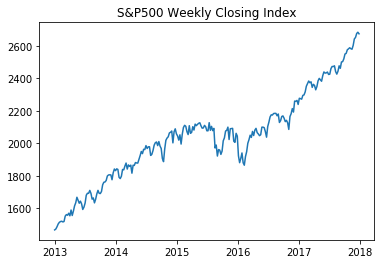

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
%load_ext rpy2.ipython
%matplotlib inline

df = pd.read_csv('D:/data/sp500-weekly.csv', index_col = 'Date')
df.index = pd.to_datetime(df.index)
df = df.drop('Adj Close', 1)
ts = df['Close']
plt.plot(ts)
plt.title('S&P500 Weekly Closing Index')

Text(0.5,1,'Log Transformation')

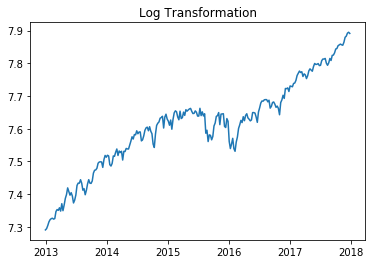

In [2]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.title("Log Transformation")

Text(0.5,1,'Log Differencing')

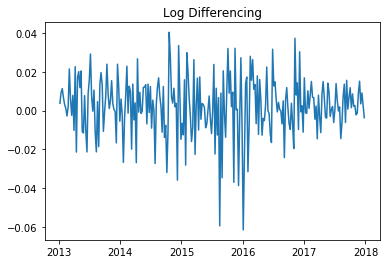

In [3]:
ts_log_diff = ts_log.diff(1)
ts_log_diff.dropna(inplace = True)
plt.plot(ts_log_diff)
plt.title("Log Differencing")

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels


def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    rol_mean = timeSeries.rolling(window=size).mean()
    rol_weighted_mean = timeSeries.ewm(span=12,min_periods=0,
                                   adjust=True,ignore_na=False).mean()
    rol_std = timeSeries.rolling(window = size).std()


    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    rol_std.plot(color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

def draw_acf_pacf(ts, lags=31):
    plot_acf(ts, lags=lags)
    plot_pacf(ts, lags=lags)
    plt.show()

## Stationarity Test

In [5]:
testStationarity(ts_log_diff)

Test Statistic                -7.856133e+00
p-value                        5.436661e-12
#Lags Used                     6.000000e+00
Number of Observations Used    2.530000e+02
Critical Value (1%)           -3.456464e+00
Critical Value (5%)           -2.873033e+00
Critical Value (10%)          -2.572895e+00
dtype: float64

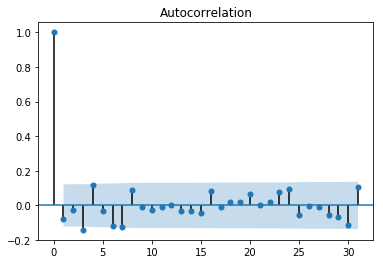

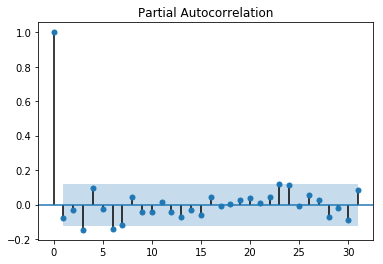

In [6]:
draw_acf_pacf(ts_log_diff)

## ARMA Modeling

In [7]:
%%R -i ts_log_diff -o out
library(TSA)
library(lmtest)
out = eacf(ts_log_diff)

In [8]:
print(out)

$eacf

            [,1]        [,2]        [,3]        [,4]        [,5]        [,6]

[1,] -0.08006744 -0.02474475 -0.14148043  0.11836773 -0.03328412 -0.12169199

[2,] -0.33981528  0.01317648 -0.10335751  0.07602206 -0.03087061 -0.04114166

[3,] -0.20381940 -0.30615751 -0.12408193 -0.02908504 -0.08579507  0.02101687

[4,]  0.45899489  0.15013635 -0.27589720  0.05267593 -0.08506850 -0.07183669

[5,]  0.26172776  0.09487245 -0.22680239 -0.37779891 -0.01422365 -0.12522698

[6,] -0.18021392  0.34288836 -0.00884836 -0.34704217  0.07113087 -0.09763042

[7,] -0.49615568  0.34149677 -0.01287160 -0.39127174  0.34501613 -0.26225100

[8,]  0.32192172 -0.11565843 -0.30397696 -0.06777323 -0.14204785 -0.24573206

           [,7]        [,8]         [,9]         [,10]         [,11]

[1,] -0.1222191  0.08906983 -0.010317458 -2.841950e-02 -0.0088920030

[2,] -0.1494104  0.07472113 -0.028264516 -2.191043e-02 -0.0194831834

[3,] -0.1613245 -0.03024514 -0.060843582  5.293770e-06 -0.0059329332

[4,] -0.164

### Choose ARMA(1,1)

Text(0.5,1,'RSS: 0.0569')

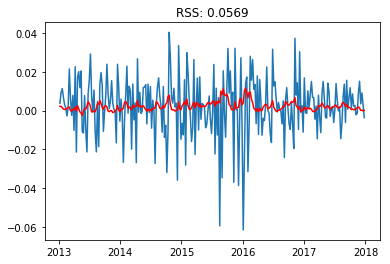

In [9]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_log_diff, order = (1,1))
result_arma = model.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(result_arma.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((result_arma.fittedvalues-ts_log_diff)**2))

In [10]:
print("AIC:", result_arma.aic)
print(result_arma.params)

AIC: -1445.360878227702
const          0.002251
ar.L1.Close    0.760026
ma.L1.Close   -0.862050
dtype: float64


## Residuals Examination

Text(0.5,1,'Residuals')

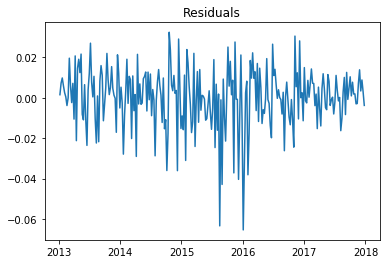

In [11]:
plt.plot(result_arma.resid)
plt.title("Residuals")

Ljung-Box test: p-values shown in the lower array.

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox
residual = result_arma.resid
ljungbox(residual)

(array([  3.27910934e-04,   2.94357423e-01,   2.32382189e+00,
          7.52030706e+00,   7.54685687e+00,   1.02443500e+01,
          1.32028542e+01,   1.52983635e+01,   1.53028089e+01,
          1.54355923e+01,   1.54418400e+01,   1.54584127e+01,
          1.56117179e+01,   1.57613846e+01,   1.60539022e+01,
          1.82153047e+01,   1.82364309e+01,   1.86073237e+01,
          1.91120869e+01,   2.10825077e+01,   2.13117538e+01,
          2.18833532e+01,   2.44197409e+01,   2.76994799e+01,
          2.81085677e+01,   2.81253295e+01,   2.81267287e+01,
          2.88945298e+01,   3.01033204e+01,   3.33772532e+01,
          3.64403533e+01,   3.64588319e+01,   3.73194059e+01,
          3.75160650e+01,   3.76952956e+01,   3.81723329e+01,
          3.83965317e+01,   3.91760233e+01,   3.93230312e+01,
          3.99848793e+01]),
 array([ 0.98555245,  0.86313971,  0.50797263,  0.11081716,  0.18304104,
         0.11473193,  0.06731745,  0.0535971 ,  0.08294714,  0.11696949,
         0.1631494 ,

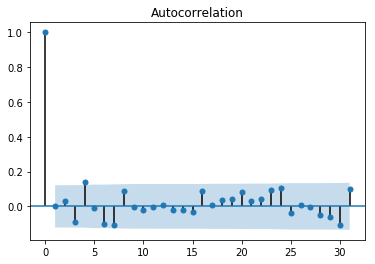

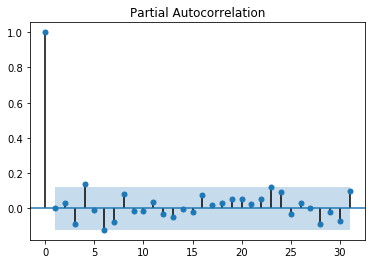

In [12]:
draw_acf_pacf(result_arma.resid)

** Testing Squared Residuals **

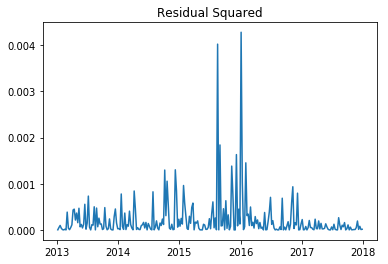

(array([  0.74603866,   5.18063639,   5.18595102,  24.34066182,
         25.33048539,  25.52265351,  29.71095874,  35.81025407,
         36.01528298,  36.0301249 ,  36.03382155,  38.81375131,
         39.08758874,  39.10795627,  39.62679299,  43.34869141,
         43.52362541,  46.69497006,  46.69562869,  69.3797775 ,
         69.99605451,  70.00878073,  70.06440974,  77.84153539,
         77.88890944,  77.99970343,  78.185235  ,  78.53808708,
         78.56237007,  80.11921195,  80.12297553,  80.56698048,
         81.41339789,  81.92182975,  82.57214041,  82.86919108,
         83.6227601 ,  83.68509084,  83.80549236,  83.81043829]),
 array([  3.87733318e-01,   7.49961729e-02,   1.58676420e-01,
          6.82478744e-05,   1.20281013e-04,   2.73151826e-04,
          1.07278329e-04,   1.90216129e-05,   3.93997848e-05,
          8.31785540e-05,   1.67058181e-04,   1.12932731e-04,
          1.93607270e-04,   3.50982524e-04,   5.16186684e-04,
          2.47578392e-04,   4.02467130e-04,   2.

In [13]:
residual_2 = residual*residual
plt.plot(residual_2)
plt.title("Residual Squared")
plt.show()
ljungbox(residual_2)

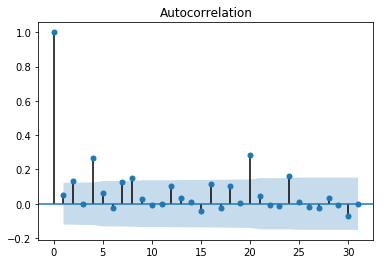

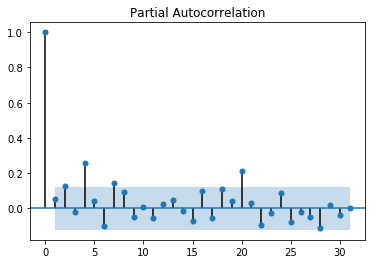

In [14]:
draw_acf_pacf(residual_2)

In [15]:
%%R -i residual_2 -o out2
library(TSA)
library(lmtest)
out2 = eacf(residual_2)

** We choose arch(4)  ** or garch(4,0) if you like :)

Text(0.5,1,'Arch(4,0) Model\nRSS: 0.00004922')

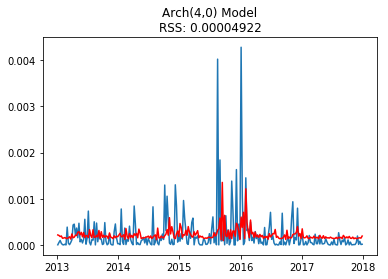

In [29]:
from statsmodels.tsa.arima_model import ARMA
model3 = ARMA(residual_2, order = (4,0))
result3_arma = model3.fit(disp = -1)
plt.plot(residual_2)
plt.plot(result3_arma.fittedvalues, color = 'red')
plt.title('Arch(4,0) Model\nRSS: %.8f'% sum((result3_arma.fittedvalues-residual_2)**2))

In [28]:
print("AIC ", result3_arma.aic)
print(result3_arma.params)

AIC  -3274.6728914465543
const      0.000216
ar.L1.y    0.052311
ar.L2.y    0.094464
ar.L3.y   -0.030168
ar.L4.y    0.258701
dtype: float64
